In [39]:
###   Imports and Logging   ###
import sys
import logging
import math
import copy
import numpy as np
import pandas as pd
import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib import __version__ as pltver
import matplotlib.ticker as ticker
from skaero.atmosphere import coesa
from skaero import __version__ as skver
import pint
units = pint.UnitRegistry()


logging.basicConfig(
    level=logging.INFO,
    format=' %(asctime)s -  %(levelname)s -  %(message)s'
)

logging.info('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')
logging.info('Python version: {}'.format(sys.version))
logging.info('Author: Benjamin Crews')
logging.info('Numpy version: {}'.format(np.version.version))
logging.info('Pandas version: {}'.format(pd.__version__))
logging.info('Matplotlib version: {}'.format(pltver))
logging.info('SciKit-Aero version: {}'.format(skver))
logging.info('Pint version: {} (using standard UnitRegistry)'.format(pint.__version__))
logging.info('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')

 2020-04-08 19:52:18,109 -  INFO -  =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
 2020-04-08 19:52:18,110 -  INFO -  Python version: 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
 2020-04-08 19:52:18,111 -  INFO -  Author: Benjamin Crews
 2020-04-08 19:52:18,111 -  INFO -  Numpy version: 1.16.2
 2020-04-08 19:52:18,117 -  INFO -  Pandas version: 0.24.2
 2020-04-08 19:52:18,132 -  INFO -  Matplotlib version: 3.0.3
 2020-04-08 19:52:18,134 -  INFO -  SciKit-Aero version: 0.1
 2020-04-08 19:52:18,136 -  INFO -  Pint version: 0.11 (using standard UnitRegistry)
 2020-04-08 19:52:18,138 -  INFO -  =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


In [83]:
#######################################
###   Input Rotor Characteristics   ###
#######################################
# Main Rotor
D = 35*units.ft
R = D/2           # units automatically carried over
b = 4             # [number of blades, no units]
CHORD = 10.4*units.inch
OMEGA = 43.2*units.rad/units.s
# Rotor Solidity
sol = b*CHORD.to(units.ft)/(math.pi*R)
# Rotor Area
A = math.pi*R**2
v_tip = OMEGA*R
v_tip = v_tip.to(units.ft/units.s)


#########################################
###   Input Vehicle Characteristics   ###
#########################################

# Vehicle Data
GW = 5000
# Assume a 3% download
THRUST = 1.03*GW

# Tail Data
# Tail length to TR center of thrust
l_tail = 21.21
# Vertical tail area
S_vt = 20.92   # [ft]
# Vertical tail lift coef.
cl_vt = 0.22   # []
# Vertical tail aspect ratio
AR_vt = 3
# Tail Rotor diameter
D_tr = 5.42    # [ft]
R_tr = D_tr/2
CHORT_tr = 7   # [in]
v_tip_tr = 650 # [ft/s]
sol_tr = 0.2741 # []
cd0_tr = 0.015  # []

# Engine Data
eta_MRxsmn = 0.985   # []
eta_TRxsmn = 0.9712  # []
eta_xsmn_co = 0.986  # []
pwr_acc = 10         # [hp]
eta_inst = 0.95
xsmn_lim = 674       # [hp]


######################################
###       Ambient Conditions       ###
######################################
alt = 0     # coesa does not support pint units? (untested) value in [m]
atm = coesa.table(alt) # an atmosphere at 0 height

# Give the atmosphere units and convert them to imperial.
prop_units =  [units.m, units.kelvin, units.pascal, units.kg/(units.m**3)]
h = atm[0]*prop_units[0]
h = h.to(units.ft)
T = atm[1]*prop_units[1]
T = T.to(units.fahrenheit)
p = atm[2]*prop_units[2]
p = p.to(units.psi)
rho = atm[3]*prop_units[3]
rho = rho.to(units.slug/(units.ft**3))


# Spit out the converted input to the log (and make it readable)
logging.info('')
logging.info('-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-')
logging.info('Main Rotor Inputs:')
logging.info('   {name:>17}: {val:>7.3f} [{unit:~}]'.format(name='Diameter', val=D.magnitude, unit=D.units))
logging.info('   {name:>17}: {val:>7.3f} [{unit:~}]'.format(name='(constant) Chord', val=CHORD.magnitude, unit=CHORD.units))
logging.info('   {name:>17}: {val:>7.3f} [{unit}]'.format(name='Num Blades', val=b, unit=''))
logging.info('   {name:>17}: {val:>7.3f} [{unit:~}]'.format(name='Rotational Speed', val=OMEGA.magnitude, unit=OMEGA.units))
logging.info('   {name:>17}: {val:>7.3f} [{unit:~}]'.format(name='Tip Speed', val=v_tip.magnitude, unit=v_tip.units))
logging.info('   {name:>17}: {val:>7.3f} [{unit:~}]'.format(name='Area', val=A.magnitude, unit=A.units))
logging.info('   {name:>17}: {val:>7.3f} [{unit:~}]'.format(name='Solidity', val=sol.magnitude, unit=sol.units))
logging.info('-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-')
logging.info('Atmospheric Properties:')
logging.info('   {name:>17}: {val:>9.5f} [{unit:~}]'.format(name='Altitude', val=h.magnitude, unit=h.units))
logging.info('   {name:>17}: {val:>9.5f} [{unit:~}]'.format(name='Temperature', val=T.magnitude, unit=T.units))
logging.info('   {name:>17}: {val:>9.5f} [{unit:~}]'.format(name='Pressure', val=p.magnitude, unit=p.units))
logging.info('   {name:>17}: {val:>9.5f} [{unit:~}]'.format(name='Density', val=rho.magnitude, unit=rho.units))
logging.info('-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-')
logging.info('')

 2020-04-08 22:04:16,653 -  INFO -  
 2020-04-08 22:04:16,654 -  INFO -  -.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
 2020-04-08 22:04:16,654 -  INFO -  Main Rotor Inputs:
 2020-04-08 22:04:16,655 -  INFO -              Diameter:  35.000 [ft]
 2020-04-08 22:04:16,655 -  INFO -      (constant) Chord:  10.400 [in]
 2020-04-08 22:04:16,657 -  INFO -            Num Blades:   4.000 []
 2020-04-08 22:04:16,658 -  INFO -      Rotational Speed:  43.200 [rad / s]
 2020-04-08 22:04:16,658 -  INFO -             Tip Speed: 756.000 [ft / s]
 2020-04-08 22:04:16,659 -  INFO -                  Area: 962.113 [ft ** 2]
 2020-04-08 22:04:16,660 -  INFO -              Solidity:   0.063 []
 2020-04-08 22:04:16,661 -  INFO -  -.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
 2020-04-08 22:04:16,662 -  INFO -  Atmospheric Properties:
 2020-04-08 22:04:16,662 -  INFO -              Altitude:   0.00000 [ft]
 2020-04-08 22:04:16,663 -  INFO -           Temperature:  59.00000 [°F]
 2020-04-08 22:04:16,664 -  INF

In [65]:
######################################
###  Blade Downwash Distribution   ###
###           (HOGE)               ###
######################################
logging.info('-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-')
logging.info('Beginning HOGE Downwash calculations...')
# To iterate on downwash solution, a function to calculate rotor thrust must
# be defined to take tip_angle as an input.
# Then, scipy.minimize can be used to reach zero error.

# TEMP: Inputs
delta_1 = -0.0216
delta_2 = 0.4
k_i = 1.1
CLIMB_RATE = 0   #[ft/min]
CLIMB_RATE = CLIMB_RATE/60  # Convert to [ft/s]

def thrust_generator(num: int,
                    TWIST: int,
                    theta_tip: float,
                    sol: float,
                    LIFT_CURVE_SLOPE: float,
                    v_tip: float,
                    CLIMB_RATE: float,
                    R: float,
                    B: float = 1.0
                   ) -> pd.DataFrame:
    '''
    Note: Despite the name, this function is not a pythonic generator.
    
    This function generates a thrust table for a rotor,
    using Blade-Element-Momentum Theory.
    
    This model assumes a constant-chord blade with no root cut-out,
    and a linear twist.
    '''
    df = pd.DataFrame(np.linspace(0.001, B, num), columns=['x'])
    df['theta'] = TWIST*(df.x - 1) + theta_tip

    c_1 = sol*LIFT_CURVE_SLOPE*v_tip/16
    c_2 = CLIMB_RATE/2 + sol*LIFT_CURVE_SLOPE*v_tip/16
    c_3 = 4*CLIMB_RATE**2/(sol*LIFT_CURVE_SLOPE*v_tip)

    # create a temporary variable which is a function of
    # blade station and blade-element angle
    # used to calculate the final induced velocity.
    df['v_step'] = 2*(np.radians(df.theta)*df.x*v_tip - CLIMB_RATE)
    df['v_induced'] = c_2 * (-1 + np.sqrt(1 + df.v_step/(c_3 + CLIMB_RATE + c_1)))
    # Calculate the differential thrust of each blade element
    # Until I know a way to elegantly do this with pandas
    # convert everything to np arrays and loop through
    # TODO: cleanup code
    x_temp = np.array(df.x)
    x_temp = np.append(x_temp, 0)
    vi_temp = np.array(df.v_induced)
    vi_temp[-1] = 0
    df['v_induced'] = -vi_temp
    dT_temp = np.array([])
    for i, vi in enumerate(vi_temp):
        dT_temp = np.append(dT_temp, 2*math.pi*rho*(CLIMB_RATE+vi)*vi*x_temp[i]*R*R*(x_temp[i+1] - x_temp[i]) )


    df['dT'] = dT_temp
    
    return df


def T_err(theta, req, args):
    '''
    Calculates the thrust error for iteration.
    '''
    df = thrust_generator(num = args[0],
                          TWIST = args[1],
                          theta_tip = theta,
                          sol = args[2],
                          LIFT_CURVE_SLOPE= args[3],
                          v_tip = args[4],
                          CLIMB_RATE = args[5],
                          R = args[6],
                          B = args[7]
                         )
    
    calcd = df.dT.sum()
    err = abs(req-calcd)/req
    return err
    

###   Airfoil Lift factor correction from 2d to 3d   ###

# TODO: a_0 = 2*pi ; a = a_0 / (1 + 57.3*a_0/(pi*AR))
# 2pi is the ideal, infinite airfoil with no edge effects.
# This equation transforms it into a 3d lift-curve-slope
# 57.3 means a is in cl/rad, but 2pi is cl/deg. So convert to rad first.

# TODO: AR = R/C
# Aspect ratio is Rotor radius over the equivalent chord.
ASPECT_RATIO = R/CHORD

a_0 = 2*math.pi*units.deg
a = a_0 / (1 + 57.3*a_0/(math.pi*ASPECT_RATIO))



###   Compressibility correction factor   ###

# TODO: 1st term of 3-term profile drag is for compressible flow only.
#       need to correct this to account for compressibilty of such a fast
#       moving rotor.
#       delta_0, the 1st drag term, is: d_0i/(sqrt(abs(Mach#**2 - 1)))
#       d_0i, the uncorrected 1st term, is given.

# The Mach num here is the mach @ 80% blade station = v_tip*0.8/c_sound
# c_sound is the local speed of sound, aka sqrt(gamma*R*T) = sqrt(1.4*1716.4*T), where T is in Rankine.
c_sound = math.sqrt(1.4*1716.4*T.to(units.rankine).magnitude)
mach_08 = v_tip.magnitude*0.8/c_sound
delta_0 = 0.0080/math.sqrt(abs(mach_08**2 - 1))


# TODO: Get Ct from Momentum theory = T/(rho*A*v_tip**2)
Ct_mom = THRUST/(rho*A*v_tip**2)
Ct_mom = Ct_mom.magnitude

# TODO: Get B correction for tip-loss = 1 - (sqrt(2*Ct)/b)
B = 1 - math.sqrt(2*Ct_mom)/b

# TODO: ideal to linear twist correction
#       Power*correction = linear-twist power, based on ideal momentum theory calculations.
#       HP_i*k_i = HP_lin , k_i is given, usually 5-10% more (k_i=1.1)
#       HP_i = Power (converted to horsepower)
#       Power = C_p*rho*A*v_tip**3
#       C_p = C_q = 3-term drag model


C_qi = 0.5*Ct_mom*math.sqrt( (CLIMB_RATE/(OMEGA.magnitude*R.magnitude))**2 + 2*Ct_mom/B**2 )
C_qvi = CLIMB_RATE*Ct_mom/(2*OMEGA.magnitude*R.magnitude)
C_q0 = sol.magnitude*delta_0/8
C_q1 = (2*delta_1/(3*a.magnitude))*(Ct_mom/B**2)
C_q2 = (4*delta_2/(sol.magnitude*a.magnitude**2))*(Ct_mom/B**2)**2

C_q = C_qi + C_qvi + C_q0 + C_q1 + C_q2

P = C_q*rho.magnitude*A.magnitude*v_tip.magnitude**3
HP_i = P/550   # Power, in horsepower
HP_i = HP_i*units.horsepower
HP = HP_i * k_i
Q = HP.magnitude*550*R.magnitude/v_tip.magnitude
Q = Q*units.lb*units.ft


# To do calculations, we pulled only the magnitudes
# add the units back in, for nice printing. (HACK, please correct later. No time now. TODO)
a = a/units.deg
P = P*units.ft*units.lb/units.s



logging.info('   {name:>18}: {val:>9.5f} [{unit:~}]'.format(name='3D Lift Coef.', val=a.magnitude, unit=a.units))
logging.info('')
logging.info('Compressibility Correction: ')
logging.info('   {name:>18}: {val:>9.5f} [{unit:}]'.format(name='0.8STA Mach Num', val=mach_08, unit=''))
logging.info('   {name:>18}: {val:>9.5f} [{unit:}]'.format(name='delta_0', val=delta_0, unit=''))
logging.info('')
logging.info('According to pure Momentum Theory: ')
logging.info('   {name:>18}: {val:>10.3E} [{unit:}]'.format(name='Coef. of Thrust', val=Ct_mom, unit=''))
logging.info('   {name:>18}: {val:>10.3f} [{unit:}]'.format(name='Tip-Loss Factor', val=B, unit=''))
logging.info('   {name:>18}: {val:>10.3E} [{unit:}]'.format(name='C_qi', val=C_qi, unit=''))
logging.info('   {name:>18}: {val:>10.3E} [{unit:}]'.format(name='C_qvi', val=C_qvi, unit=''))
logging.info('   {name:>18}: {val:>10.3E} [{unit:}]'.format(name='C_q0', val=C_q0, unit=''))
logging.info('   {name:>18}: {val:>10.3E} [{unit:}]'.format(name='C_q1', val=C_q1, unit=''))
logging.info('   {name:>18}: {val:>10.3E} [{unit:}]'.format(name='C_q2', val=C_q2, unit=''))
logging.info('   {name:>18}: {val:>10.3E} [{unit:}]'.format(name='Coef. of Pwr/Torq', val=C_q, unit=''))
logging.info('   {name:>18}: {val:>10.3E} [{unit:~}]'.format(name='Total, Ideal Power', val=P.magnitude, unit=P.units))
logging.info('   {name:>18}: {val:>10.3f} [{unit:~}]'.format(name='Corrected Power', val=HP.magnitude, unit=HP.units))
logging.info('   {name:>18}: {val:>10.3f} [{unit:~}]'.format(name='Total Torque', val=Q.magnitude, unit=Q.units))
logging.info('-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-')
logging.info('')

 2020-04-08 20:22:13,316 -  INFO -  -.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
 2020-04-08 20:22:13,317 -  INFO -  Beginning HOGE Downwash calculations...
 2020-04-08 20:22:13,320 -  INFO -          3D Lift Coef.:   5.71690 []
 2020-04-08 20:22:13,322 -  INFO -  
 2020-04-08 20:22:13,322 -  INFO -  Compressibility Correction: 
 2020-04-08 20:22:13,323 -  INFO -        0.8STA Mach Num:   0.54174 []
 2020-04-08 20:22:13,324 -  INFO -                delta_0:   0.00952 []
 2020-04-08 20:22:13,324 -  INFO -  
 2020-04-08 20:22:13,324 -  INFO -  According to pure Momentum Theory: 
 2020-04-08 20:22:13,325 -  INFO -        Coef. of Thrust:  3.940E-03 []
 2020-04-08 20:22:13,326 -  INFO -        Tip-Loss Factor:      0.978 []
 2020-04-08 20:22:13,327 -  INFO -                   C_qi:  1.789E-04 []
 2020-04-08 20:22:13,328 -  INFO -                  C_qvi:  0.000E+00 []
 2020-04-08 20:22:13,328 -  INFO -                   C_q0:  7.502E-05 []
 2020-04-08 20:22:13,328 -  INFO -                

In [43]:
## Note: With all the correction factors above, we have a roughly approximate solution
#        for realistic power, using just momentum theory. The blade-element portion
#        is not necessary yet.

#########################################
###   Blade-Element Momentum Theory   ###
###     Downwash Distribution         ###
###            (HOGE)                 ###
#########################################

args = (50, -12, sol.magnitude, a.magnitude, v_tip.magnitude, CLIMB_RATE, R.magnitude, 1)
res = scipy.optimize.minimize(T_err, x0=2, args=(THRUST, args), tol=0.01, options={'disp':True})
logging.info('  SciPy Optimization resulted in theta_tip = {:.3f}, after {} iterations.'.format(res.x[0], res.nfev))
logging.info('  Using optimization results to calculate Main Rotor data...')
logging.info('')
theta = res.x[0]
MR = thrust_generator(num = args[0],
                          TWIST = args[1],
                          theta_tip = theta,
                          sol = args[2],
                          LIFT_CURVE_SLOPE= args[3],
                          v_tip = args[4],
                          CLIMB_RATE = args[5],
                          R = args[6],
                          B = args[7]
                         )

logging.info(f'   Total Main Rotor Thrust = {MR.dT.sum():10.2f} [lb]')
logging.info('')
logging.info('Blade Station Downwash Table: ')
print(MR)

D:\Czarified\Anaconda3\lib\site-packages\numpy\core\numeric.py:591: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Czarified\Anaconda3\lib\site-packages\numpy\core\numeric.py:591: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
 2020-04-08 19:53:02,219 -  INFO -    SciPy Optimization resulted in theta_tip = 10.092, after 309 iterations.
 2020-04-08 19:53:02,219 -  INFO -    Using optimization results to calculate Main Rotor data...
 2020-04-08 19:53:02,220 -  INFO -  
D:\Czarified\Anaconda3\lib\site-packages\numpy\core\numeric.py:591: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
 2020-04-08 19:53:02,235 -  INFO -     Total Main Rotor Thrust =    5150.00 [lb]
 2020-04-08 19:53:02,23

         Current function value: 0.000000
         Iterations: 1
         Function evaluations: 309
         Gradient evaluations: 99
           x      theta      v_step  v_induced          dT
0   0.001000  22.080278    0.582685  -0.288892    0.000008
1   0.021388  21.835625   12.324236  -5.328607    0.056627
2   0.041776  21.590972   23.802530  -9.340294    0.339842
3   0.062163  21.346319   35.017568 -12.742419    0.941179
4   0.082551  21.101666   45.969349 -15.725454    1.903546
5   0.102939  20.857013   56.657873 -18.395421    3.248127
6   0.123327  20.612360   67.083141 -20.818625    4.984197
7   0.143714  20.367707   77.245153 -23.039859    7.113678
8   0.164102  20.123054   87.143908 -25.091084    9.633574
9   0.184490  19.878401   96.779406 -26.996068   12.537414
10  0.204878  19.633748  106.151648 -28.773060   15.816161
11  0.225265  19.389095  115.260633 -30.436437   19.458821
12  0.245653  19.144442  124.106362 -31.997763   23.452870
13  0.266041  18.899789  132.688834 -33.

In [46]:
#######################################
###   Forward Flight Calculations   ###
#######################################
logging.info('Beginning Forward Flight Calculations...')


    #    Main Rotor Calculations
    ##################################

# Max Airspeed, in knots
VNE = 160
fe = 12.4 * units.ft**2     # Equivalent Flat-Plate Drag Area


df = pd.DataFrame(data=[20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 130, 140, 150, 160], columns=['Airspeed'])

# Dynamic Pressure = 1/2 rho V^2
df['q'] = 0.5*rho.magnitude*(df.Airspeed * 1.68781)**2    # 1.689 is simply the conversion factor from kts to ft/s

# Advance Ratio
df['mu'] = df.Airspeed * 1.689 / v_tip.magnitude

# Hover Induced Velocity
v_0 = math.sqrt(THRUST/(2*rho.magnitude*math.pi*R.magnitude**2))
# Induced velocity in Forward Flight, using Glauert's Model
df['v_if'] = v_0 * (-0.5*(df.Airspeed/v_0)**2 + np.sqrt((df.Airspeed/v_0)**4 / 4 + 1))

# Thrust coef. over solidity
df['Cts'] = THRUST/(rho.magnitude*A.magnitude*v_tip.magnitude**2) / sol.magnitude

# Blade loading
df['tc'] = 2*df.Cts

# Empirical lower bound of blade loading
df['tc_lower'] = -0.6885*df.Cts + 0.3555

# Change in Drag Coef. (due to retreating blade stall)
# From a NASA CR
df['F'] = ((df.Cts/(1-df.mu)**2) * (1 + fe.magnitude*df.q/GW)) - 0.1376
df['del_cds'] = 18.3*(1-df.mu)**2*df.F**3
# This value should never be less than zero, so clip it.
df.del_cds.clip(lower=0, inplace=True)

# Mach Drag Divergence of the airfoil: At what Mach would shockwaves start to form?
df['MDD'] = 0.82 - 2.4*df.Cts

# MY90. Mach at the tip
df['MY90'] = (df.Airspeed*1.68781 + v_tip.magnitude)/c_sound

# Change in Drag Coef. from compressibility
df['del_cdcomp'] = 0.2*(df.MY90 - df.MDD)**3 + 0.0085*(df.MY90 - df.MDD)

# Total Drag Coef.
df['cd'] = 0.0095 + df.del_cds + df.del_cdcomp

# Induced Horsepower
df['Hp_ind'] = THRUST*df.v_if/550

# Profile Horsepower
df['Hp_pro'] = sol.magnitude*df.cd*(1+4.65*df.mu**2)*rho.magnitude*math.pi*R.magnitude**2*v_tip.magnitude**3/4400

# Parasite Power
df['Hp_par'] = fe.magnitude*rho.magnitude*(df.Airspeed*1.68781)**3/1100

# Main Rotor Horsepower
df['MR_hp'] = df.Hp_ind + df.Hp_pro + df.Hp_par

# Main Rotor Torque
df['MR_Q'] = 5252*df.MR_hp/(OMEGA.magnitude*60/(2*math.pi))

# Anti-torque Required from Tail Rotor Thrust
# MR Torque over the moment arm
df['T_at'] = df.MR_Q/(2*l_tail)

MR = df.copy()

 2020-04-08 20:07:30,532 -  INFO -  Beginning Forward Flight Calculations...


In [76]:

    #    Tail Rotor Calculations
    #################################

# Copy the dataframe to a new variable, for Tail calculations
# Carry over the airspeed and anti-torque thrust
TR = pd.DataFrame(data=MR.Airspeed)
TR['T_at'] = MR.T_at.copy()
TR['q'] = MR.q.copy()

# Calculate the anti-torque provided
# by the vertical tail
# Lift = cl*wing_area*dynamic_pressure
TR['L_vt'] = cl_vt*S_vt*TR.q

# Anti-torque minus Vfin Lift
TR['TTR'] = TR.T_at - TR.L_vt

# Induced Drag from the Vfin
TR['D_vt'] = TR.L_vt**2/(2*TR.q*S_vt*AR_vt)

# Calculate the "hover induced velocity" of TR
TR['v0_tr'] = np.sqrt(abs(TR.TTR)/(2*rho.magnitude*math.pi*R_tr**2))

# Calculate the forward flight induced velocity
TR['v_if_tr'] = TR.v0_tr * (-0.5*(TR.Airspeed/TR.v0_tr)**2 + np.sqrt((df.Airspeed/TR.v0_tr)**4 / 4 + 1))

# Induced Horsepower
TR['HP_i_tr'] = TR.TTR*TR.v_if_tr/550

# Profile Horsepower
TR['HP_pro_tr'] = sol_tr*cd0_tr*(1+4.65*MR.mu**2)*rho.magnitude*math.pi*R_tr**2*v_tip_tr**3 / 4400

# Total TR Horsepower
TR['HP_tr'] = TR.HP_i_tr + TR.HP_pro_tr

In [86]:

    #   Power Calculations
    #############################

Power = pd.DataFrame(data=MR.Airspeed)
Power['MR_hp'] = MR.MR_hp.copy()
Power['TR_hp'] = TR.HP_tr.copy()

Power['del_MRxsmn'] = Power.MR_hp*(1-(eta_MRxsmn*eta_xsmn_co))
Power['del_TRxsmn'] = Power.TR_hp*(1-eta_TRxsmn)
Power['del_Acc_co'] = pwr_acc*(1-eta_xsmn_co)

Power['SHP_inst_req'] = Power.MR_hp + Power.TR_hp + Power.del_MRxsmn \
                      + Power.del_TRxsmn + pwr_acc + Power.del_Acc_co

Power['del_inst'] = Power.SHP_inst_req*(1-eta_inst)
Power['SHP_uninst'] = Power.SHP_inst_req + Power.del_inst

Power['L_D'] = GW*Power.Airspeed*1.689 / (550*Power.SHP_uninst)

Power

,Airspeed,MR_hp,TR_hp,del_MRxsmn,del_TRxsmn,del_Acc_co,SHP_inst_req,del_inst,SHP_uninst,L_D
0,20,404.809354,19.826086,11.654461,0.570991,0.14,447.000893,22.350045,469.350938,0.654288
1,30,360.480709,17.401426,10.378240,0.501161,0.14,398.901536,19.945077,418.846613,1.099773
2,40,319.312729,15.754328,9.193013,0.453725,0.14,354.853796,17.742690,372.596486,1.648383
3,50,291.319199,15.207494,8.387080,0.437976,0.14,325.491749,16.274587,341.766336,2.246351
4,60,279.410557,15.305017,8.044230,0.440784,0.14,313.340588,15.667029,329.007617,2.800156
5,70,282.450886,15.675538,8.131761,0.451455,0.14,316.849640,15.842482,332.692122,3.230669
6,80,298.678983,16.160856,8.598968,0.465433,0.14,334.044239,16.702212,350.746451,3.502141
7,90,326.956147,16.692845,9.413067,0.480754,0.14,363.682814,18.184141,381.866955,3.618823
8,100,366.846947,17.268631,10.561524,0.497337,0.14,405.314438,20.265722,425.580160,3.607909
9,120,482.138161,18.579949,13.880758,0.535103,0.14,525.273970,26.263699,551.537669,3.340743


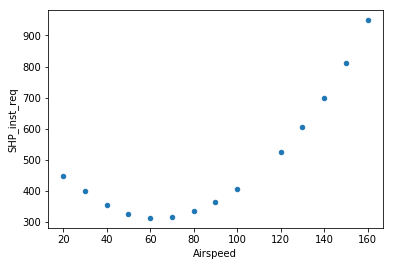

In [90]:
Power.plot(x='Airspeed', y='SHP_inst_req', kind='scatter')